<a href="https://colab.research.google.com/github/mori8/2021-winter-kaggle-study/blob/main/week1/Interactive_Porto_Insights_A_Plot_ly_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Porto Insights - A Plot.ly Tutorial

`Plot.ly`는 데이터 시각화 툴로, 웹 시각화 라이브러리인 dj.js를 이용하여 interactive한 시각화를 지원한다. matplotlib보다 코드가 간단하며, 기본 디자인도 훨씬 모던하다. 이 노트북에서는 Plot.ly를 통한 데이터 분석 방법에 대해서 알아본다.

### 주제
1. 결측값, Null 값 시각화
2. 특성 검사 및 필터링
3. 학습 모델의 특성 중요도 순위 파악

## Colab에서 Plot.ly 사용하기

In [28]:
!pip install --upgrade plotly

     |████████████████████████████████| 23.9 MB 14 kB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [1]:
!pip install jupyter-dash

     |████████████████████████████████| 7.3 MB 5.4 MB/s 
     |████████████████████████████████| 357 kB 48.5 MB/s 
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3821 sha256=cb1bcdbbc769f2f418d709deb1bb27b3e99fc1344e0c5a88902a826f3e8aff04
  Stored in directory: /root/.cache/pip/wheels/00/f9/c7/1a6437d794ed753ea9bc9079e761d4fc803a1f1f5d3697b9ec
  Created wheel for dash-html-components: filename=dash_html_components-2.0.0-py3-none-any.whl size=4089 sha256=dbb13c463c17d59e576c3cff0c6a27ec0b98c08180841daad4dddd2542b2e104
  Stored in directory: /root/.cache/pip/wheels/ec/6b/81/05aceabd8b27f724e2c96784016287cc1bfbc349ebfda451de
  Created wheel for dash-table: filename=dash_table-5.0.0-py3-none-any.whl size=3911 sha256=c7cda0da53510abf7dcebce6517e52000fce26dc205577fd3638720dd93a51b9
  Stored in directory: /root/.cache/pip/wheels/85/5d/4e/7c276b57992951dbe770bf5caad6448d0539c510663aefd2e2
Successfully built dash-core-components dash-html-com

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import chart_studio
chart_studio.tools.set_credentials_file(username='username', api_key='api_key')
import plotly.graph_objects as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("/content/drive/MyDrive/GDSC Sookmyung/캐글 스터디/data/week1/train.csv")
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


## 1. Data Quality Checks 결측값, Null 값 시각화

퀄리티 검사의 일환으로, 다음과 같은 방법으로 null 값이 있는지 빠르게 확인할 수 있다.

In [5]:
# any() applied twice to check run the isnull check across all columns.
# any() 1번만 사용시 -> 각 column에 null이 있는지에 대한 Bool 값을 담은 Series
# any() 2번 사용시 -> 위에서 생성된 Series에 True가 있는지에 대한 Bool == 전체 데이터셋 내에 null이 있는지에 대한 Bool
train.isnull().any().any()

False

Null 검사에서 `False`를 반환했다고 해도 이 데이터셋 내에서 결측치는 -1로 표시하고 있으므로 -1 값을 갖는 엔트리에 대해 추가적인 작업이 필요하다. 

아래의 코드를 통해 데이터셋의 모든 -1값을 null값으로 바꿀 수 있다.

In [6]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

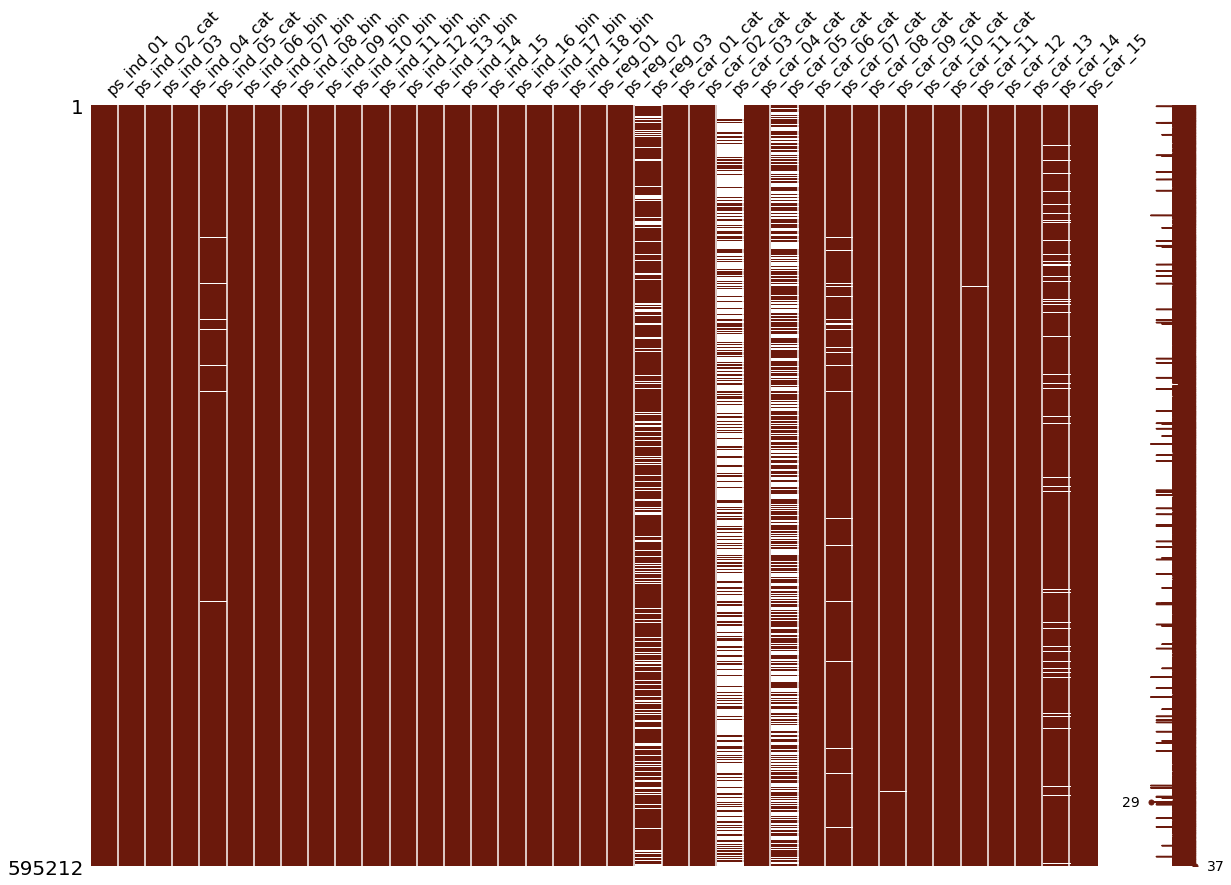

In [7]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

시각화를 통해 결측치의 분포를 명확하게 알 수 있다. 이 플롯에서 비어있는 흰색 띠가 결측 데이터를 의미한다. 이 플롯은 최대 40개까지의 열만 표시할 수 있도록 슬라이싱했으므로, 전체 13개의 결측치를 가진 열 중 7개의 열만 확인할 수 있다.
슬라이싱 인덱스와 figsize 값을 조정하면 모든 null 값을 시각화할 수 있다.

플롯을 살펴보면 결측값의 대부분은 `_cat`이 붙은 열에서 발생한다. 그리고 `ps_reg_03`, `ps_car_03_cat`, `ps_car_05_cat` 열에 대부분의 결측값이 몰려있기 때문에 null 값을 -1로 대체하는 것은 그리 좋은 전략이 아닐 수 있다.

#### Target variable inspection
점검의 다음 순서는 목표 변수(`target`) 점검이다. 

In [11]:
data = [go.Bar(
            x = train["target"].value_counts().index.values,
            y = train["target"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)
fig.show(renderer='colab')
py.iplot(fig, filename='basic-bar')

#### Datatype Check

훈련 데이터셋이 어떤 데이터 타입으로 구성되어 있는지 확인한다. Python에서 고유한 타입 게수를 구하는 방법 중 하나는 다음과 같이 Collections 모듈의 Counter 메서드를 사용하는 것이다.

In [12]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [15]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

### Correlation plots

각 특성들이 어떤 선형관계를 갖는지에 대한 통찰력을 얻기 위해 선형 상관 그래프를 생성할 것이다. 

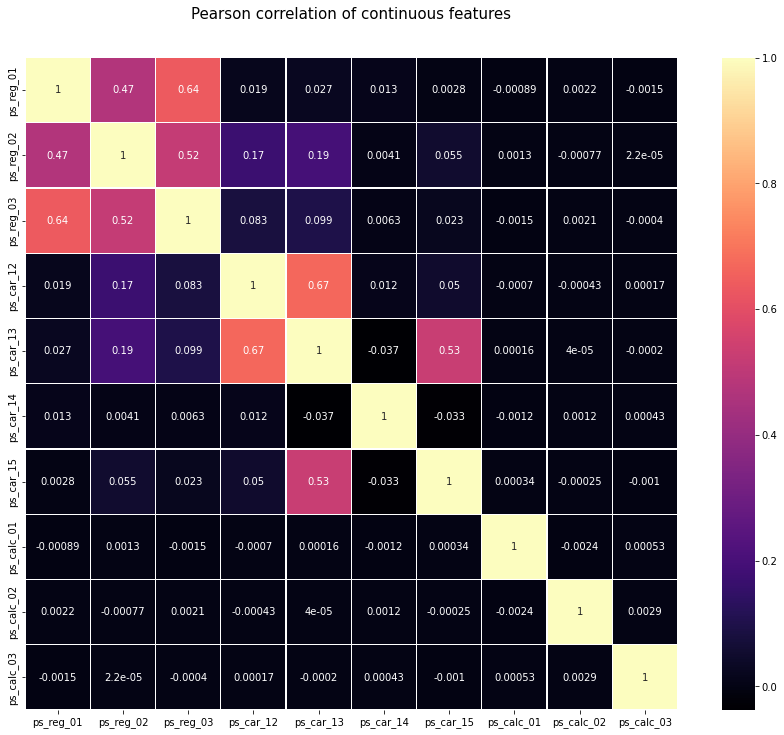

In [16]:
colormap = plt.cm.magma
plt.figure(figsize=(16, 12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

대부분의 형상이 서로 0(관계 없음)이거나 약한 상관관계를 띄운다. 양의 선형 상관관계를 띄는 쌍은 다음과 같다.

- (ps_reg_01, ps_reg_03)
- (ps_reg_02, ps_reg_03)
- (ps_car_12, ps_car_13)
- (ps_car_13, ps_car_15)

In [20]:
#train_int = train_int.drop(["id", "target"], axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21,16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_cat.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
data = [
    go.Heatmap(
        z= train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Viridis',
        reversescale = False)
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
fig.show(renderer='colab')
py.iplot(fig, filename='labelled-heatmap')

### Mutual Information Plots

상호정보를 계산할 수 있다. 0에 가까울 수록 임의의 변수가 서로 독립적임을 나타내며, 값이 높을수록 특성의 종속성을 나타낸다.
`mutual_info_classif`은 k-NN의 엔트로피 추정을 기반으로 한 비모수 방식에 따른다.

In [21]:
mf = mutual_info_classif(train_float.values,train.target.values,n_neighbors=3, random_state=17 )
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


### Binary features inspection

In [23]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [26]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
fig.show(renderer='colab')
py.iplot(fig, filename='stacked-bar')

### Feature importance via Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [28]:
# Scatter plot
trace = go.Scatter(
    y=rf.feature_importances_,
    x=features,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=12,
        # size=rf.feature_importances_,
        # color=np.random.randn(500), # set color equal to a variable
        color=rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text=features
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest',
    xaxis=dict(
        ticklen=5,
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title='Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
fig.show(renderer='colab')

In [30]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse=False)))

trace2 = go.Bar(
    x=x,
    y=y,
    marker=dict(
        color=x,
        colorscale='Viridis',
        reversescale=True
    ),
    name='Random Forest Feature importance',
    orientation='h'
)

layout = dict(
    title='Barplot of Feature importances',
    width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        # domain=[0, 0.85]
    )
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
fig1.show(renderer='colab')

#### Decision Tree visualisation

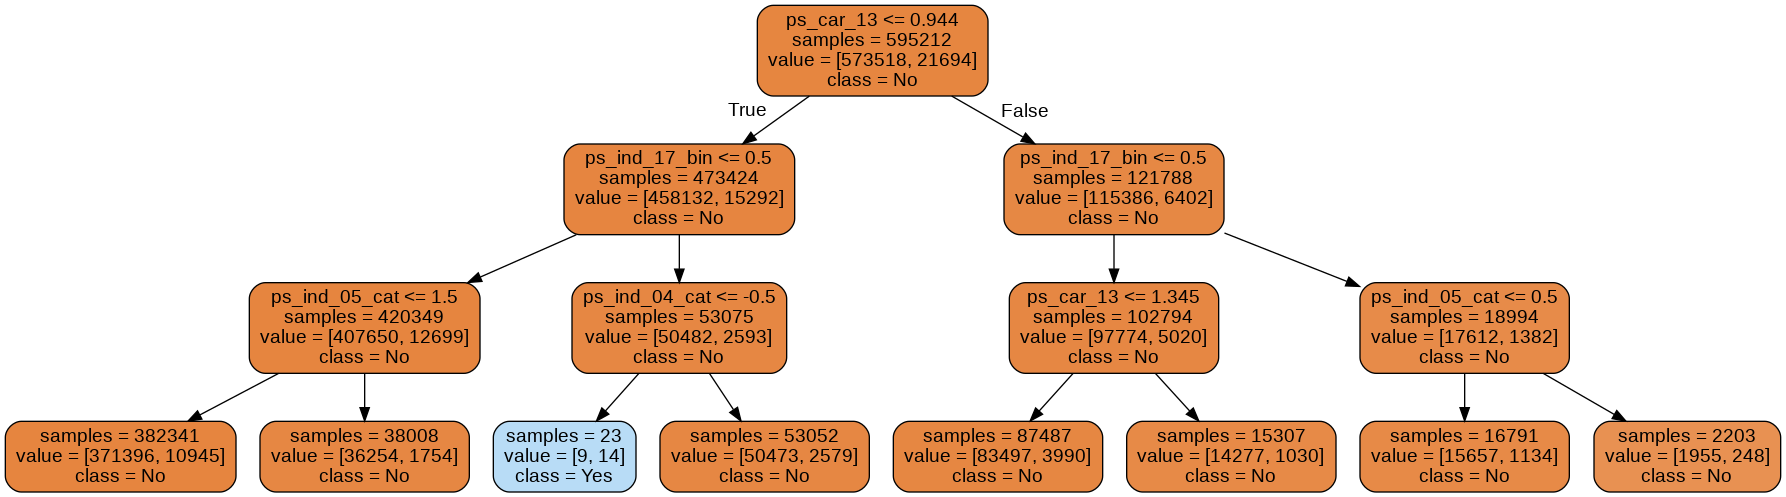

In [31]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id', 'target'], axis=1), train.target)

# Export our train model as a .dot file
with open("tree1.dot", 'w') as f:
  f = tree.export_graphviz(decision_tree,
                           out_file=f,
                           max_depth=4,
                           impurity=False,
                           feature_names=train.drop(['id', 'target'], axis=1).columns.values,
                           class_names=['No', 'Yes'],
                           rounded=True,
                           filled=True)
  
# Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

### Feature importance via Gradient Boosting Model

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [36]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
fig.show(renderer='colab')
py.iplot(fig,filename='scatter2010')

In [39]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
fig1.show(renderer='colab')

## 결론

우리는 특성의 null 값과 데이터 품질을 검사하고, 특성의 선형 상관 관계를 조사하며 특성의 분포를 검사했다. 그리고 형상의 식별을 위해 몇 가지 학습 모델(Random Boost와 Gradient Boosting 분류기)을 구현함으로써 Porto Seguro 데이터 세트의 상당히 광범위한 검사를 수행했다.